# A simple demo for Libra

This Jupyter notebook provides a demo that supports multi-instance inference for Libra in an image-based conversation scenario. Before starting a conversation, there are two preparations that need to be made *by following the instructions provided in the README*:

1. Ensure that you have correctly installed the required environments.
2. Download the pretrained weights and organize them as follows:
   
```
CHECKPOINTS/
├── libra-11b-chat/
└── ...
```

Now, to run the demo on your device, you need to make ***two*** modifications. We will highlight the specific modifications you should make below.

## Load pretrained weights.

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath('.')))
PROJECT_PATH = os.path.dirname(os.path.abspath('.'))

import torch
import numpy as np
import PIL
from PIL import Image, ImageDraw

from libra.models.libra import LibraForCausalLM, LibraTokenizer
from libra.data.datasets import conversation as conversation_lib
from libra.data import LibraEvalImageProcessor
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Modification 1:** Specify the ``PRETRAINED_PATH`` of Libra models.

In [2]:
PRETRAINED_PATH = "CHECKPOINTS/libra-11b-chat"

In [3]:
if not os.path.isabs(PRETRAINED_PATH):
    PRETRAINED_PATH = os.path.join(PROJECT_PATH, PRETRAINED_PATH)
CONVERSATION = conversation_lib.conv_templates["v1"]
NUM_VISION_TOKENS = 578
IMAGE_PLACEHOLDER = (" <img_ph>"*(NUM_VISION_TOKENS)).strip()

In [4]:
def open_image(path):
   return PIL.Image.open(path)

def preprocess(img):
   img = LibraEvalImageProcessor(pretrained_path=os.path.join(PRETRAINED_PATH, "openai-clip-vit-large-patch14-336"))(img)
   img = torch.unsqueeze(img, 0)
   return img

def get_image_input(img_path):
   image  = preprocess(open_image(img_path))
   image = image.to(DEVICE)
   return image

def get_batch_image_input(img_paths):
   if len(img_paths) == 0:
      return None
   else:
      images = []
      for img_path in img_paths:
         image = get_image_input(img_path)
         images.append(image)
      images = torch.cat(images)
      return images


def stack_reconstructions(inputs, titles=None):
   if inputs is None or len(inputs) == 0:
      return
   size = inputs[0].size
   w, h = size[0], size[1]
   num_imgs = len(inputs)
   if titles is None:
      titles = ["img_{}".format(k) for k in range(num_imgs)]
   img = Image.new("RGB", (num_imgs*w, h))
   for i, x in enumerate(inputs):
      assert x.size == size
      img.paste(x, (i*w,0))
   for i, title in enumerate(titles):
      ImageDraw.Draw(img).text((i*w, 0), f'{title}', (255, 255, 255))
   return img

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def process_prompt(prompts: list, raw_inputs: bool = False):
    text, image = [], []
    for prompt in prompts:
        if prompt.get("image", None) is not None:
            image.append(prompt["image"])
            if prompt.get("text", None) is not None:
               if '<img_ph>' not in prompt["text"]:
                  prompt["text"] = IMAGE_PLACEHOLDER + "\n" + prompt["text"]
        if prompt.get("text", None) is not None:
            if raw_inputs:
               text.append(prompt["text"])
            else:
               conv = CONVERSATION.copy()
               conv.append_message(conv.roles[0], prompt["text"])
               conv.append_message(conv.roles[1], None)
               processed_text = conv.get_prompt()
               text.append(processed_text)
    image = get_batch_image_input(image)
    contiguous_ignore_sign = [False for _ in range(len(image))]
    processed = {"language": text, "vision": image, "contiguous_ignore_sign": contiguous_ignore_sign}

    return processed

def process_results(results):
   text_results = [r['language'] for r in results]
   image_results = [r['vision'] for r in results]
   imgs = []
   for img_result in image_results:
      if img_result is None or len(img_result) == 0:
         imgs.append(None)
      else:
         imgs.append([custom_to_pil(r) for r in img_result])

   display_imgs = [stack_reconstructions(item) for item in imgs]
   i2t_results = [text_results, display_imgs]
   return i2t_results

Load the model and the tokenizer

In [5]:
model = LibraForCausalLM.from_pretrained(PRETRAINED_PATH).to(torch.bfloat16).to(DEVICE).eval()
tokenizer = LibraTokenizer(PRETRAINED_PATH).to(DEVICE)
tokenizer.text_tokenizer.padding_side = 'left'
tokenizer.text_tokenizer.add_eos_token = False

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LlamaTokenizer'. 
The class this function is called from is 'LibraTextTokenizer'.


Working with z of shape (1, 1024, 24, 24) = 589824 dimensions.
Deleting key loss.perceptual_loss.scaling_layer.shift from state_dict.
Deleting key loss.perceptual_loss.scaling_layer.scale from state_dict.
Deleting key loss.perceptual_loss.net.slice1.0.weight from state_dict.
Deleting key loss.perceptual_loss.net.slice1.0.bias from state_dict.
Deleting key loss.perceptual_loss.net.slice1.2.weight from state_dict.
Deleting key loss.perceptual_loss.net.slice1.2.bias from state_dict.
Deleting key loss.perceptual_loss.net.slice2.5.weight from state_dict.
Deleting key loss.perceptual_loss.net.slice2.5.bias from state_dict.
Deleting key loss.perceptual_loss.net.slice2.7.weight from state_dict.
Deleting key loss.perceptual_loss.net.slice2.7.bias from state_dict.
Deleting key loss.perceptual_loss.net.slice3.10.weight from state_dict.
Deleting key loss.perceptual_loss.net.slice3.10.bias from state_dict.
Deleting key loss.perceptual_loss.net.slice3.12.weight from state_dict.
Deleting key loss.per

## Start a conversation

**Modification 2:** Provide your testing prompts and images below.

If you want to discard the system message, set ``raw_inputs`` to True, otherwise False. ``raw_inputs=True`` is usually used to evaluate the pretrianed models before instruction tuning.

In [6]:
prompts = [
    # Prompts for Libra-Chat
    {
        "text": "Why is this image funny?",
        "image": "/home/yfxu/libra/images/cartoon_duck.jpg",
    },
    {
        "text": "Describe this image.",
        "image": "/home/yfxu/libra/images/libra_logo.jpg",
    },
    {
        "text": "What is unusual in this image?",
        "image": "/home/yfxu/libra/images/taxi.jpg",       
    },
    {
        "text": "Simply put, the theory of relativity states that ",
    },
    
    # Prompts for Libra-Base
    # {
    #     "text": "",
    #     "image": "/home/yfxu/libra/images/cartoon_duck.jpg",
    # },
    # {
    #     "text": "",
    #     "image": "/home/yfxu/libra/images/taxi.jpg",       
    # },   
]
temperature = 0.0
raw_inputs = False
max_new_tokens = 512

Generate answers.

In [7]:
inputs = tokenizer(process_prompt(prompts, raw_inputs=raw_inputs), padding=True)
generate_ids = model.generate(
    inputs["input_ids"], 
    attention_mask=inputs["attention_mask"], 
    vision_indices=inputs["vision_indices"], 
    contiguous_signal=inputs["coninous_signal"].to(torch.bfloat16),
    do_sample=True if temperature > 0 else False,
    temperature=temperature if temperature > 0 else None,
    use_cache=True,
    max_new_tokens=max_new_tokens,
    )
results = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
i2t_results = process_results(results)

Show the k-th results.

Output text:
A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER:<img_ph>
Why is this image funny? ASSISTANT: The image is funny because it features a cartoon duck with a surprised expression on its face. The duck is holding a donut in its beak, which is an unusual and unexpected sight. The combination of the duck's surprised expression and the donut creates a humorous and unexpected scenario that catches the viewer's attention and amuses them.
Encoded image:


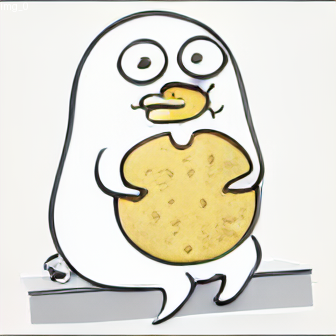

In [8]:
k=0
print("Output text:")
print(i2t_results[0][k])
print("Encoded image:")
i2t_results[1][k]